First, some imports and helper objects to set up our displays.

In [1]:
import numpy as np
import scipy.stats
from matplotlib import pylab as plt
from IPython.display import HTML,display
%matplotlib inline
# All square figures
plt.rcParams['figure.figsize'] = [6, 6]
# Make some html tables from lists
def htmltable(data):
    return '<table><tr>{}</tr></table>'.format(
            '</tr><tr>'.join(
                '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
            )
def disptable(data):
    display(HTML(htmltable(data)))
# Macro for making consistent color+markers throughout
from itertools import cycle
from collections import defaultdict
colors = cycle("rgbycmk")
markers = cycle("+x*d")
colorkey = defaultdict(lambda :colors.next())
markerkey = defaultdict(lambda :markers.next())
mykwargs = lambda s:{'color':colorkey[s],'marker':markerkey[s],'label':s}
# Change this function if you don't want to save the plots to _my_ dropbox folder
def mysavefig(fname,fig=None):
    #return
    plt.savefig("/Users/afq/Documents/Dropbox/LBL/Presentations/peridynamics/assets/plots/"+fname)

# A Comprehensive Analysis of Peridynamics

Alejandro Francisco Queiruga

**TL;DR:** I advise against the use of Peridynamics.

## Introduction

This notebook replicates some of the results of 

> Queiruga, A. F. and G. J. Moridis, "Numerical experiments on 
>  the convergence properties of state-based peridynamic laws and 
>  influence functions in two-dimensional problems." Computer 
>  Methods in Applied Mechanics and Engineering 322 (2017): 
>  97-122.

PeriFlakes, of which is this notebook is a part, is an open source implementation of Peridynamics that can quickly generate and analyze state-based schemes. The database in this repository contains a huge set of runs with many permutations on the theoretical formulations that were used to solve constant-strain problems and the thin crack problem. The original analysis was performed similarly using org-mode to embed the analysis into the the paper source. Org-mode is a bit of a beast, so I have replicated this simplified version using Jupyter. 



I like to use my [SimDataDB](https://github.com/afqueiruga/SimDataDB) wrapper for cursor and entry-adding management, but the database is just a regular `sqlite3` table. There are four tables, each with with the same five columns:

In [2]:
from SimDataDB import *
sdb = SimDataDB('PeriFlakes/results.db')
tables = [_[0] for _ in sdb.Query("SELECT name FROM sqlite_master WHERE type='table';")]
print tables
print [ (_[1],_[2]) for _ in sdb.Query("PRAGMA table_info(uniaxial)")]

[u'isotropic', u'shear', u'uniaxial']
[(u'method', u'TEXT'), (u'weight', u'TEXT'), (u'RF', u'FLOAT'), (u'N', u'INT'), (u'u', u'array')]


The first two columns label the scheme by constitutive law and weight (influence) function $w$, $RF$ is the support radius (which is also an artificial hyperparameter!), $N$ is the number of nodes along one side of the $(-1,1)\times(-1,1)$ domain, and $u$ is a binary blob of the entire numpy array storing the solution.

This a list of all of the different methods we consider:

In [3]:
print sdb.Query("SELECT DISTINCT method FROM uniaxial")

[[u'Fbased'], [u'Oterkus2'], [u'Silling']]


Oterkus2 and Silling are two different dilation based method, which we will show to not be acceptable. The method Fbased is Siling's deformation gradient based method with a correspondence to continuum mechanics

# Constant Strain Problems

The patch test in finite element analysis asserts that any new finite element must be able to exactly represent any random constant strain case with any randomly perturbed element mesh, and give exactly the correct stress. Peridynamic codes don't have that property. To investigate further, we break down the constant strain cases into three main modes:

![three modes](images/blocks.png)

(The bottom of the uniaxial and shear domains are also rollers.) These are the sorts of problems that a freshman engineering student will learn. The analytical
solution for these problems are: 

| Test      | Solution                                         |
|-----------|:------------------------------------------------:|
| Uniaxial  | $u_{y,anal}=T H \frac{ 2 \nu^2 + \nu -1 }{E(\nu-1)}$ |
| Isotropic | $u_{y,anal}=T H \frac{ 1 - \nu - 2 \nu^2 }{E}$ |
| Shear     | $u_{x,anal}=2 T H \frac{ 1+\nu}{E}$            |

The properties that we used in the problem and their solutions (stored 
next to the component index) are:

In [4]:
H = 2.0 ; T = 1.0 ; E = 1.0 ; nu = 0.25;
solutions = {'uniaxial': (1, T*H*(2.0*nu**2+nu-1.0)/(E*(nu-1))),
             'isotropic':(1, T*H*(1.0-nu-2.0*nu**2)/E),
             'shear':    (0, 2.0*T*H*(1.0+nu)/E) }

### Properties of the solutions

Let's access one of Peridynamics solutions from the database: Silling's original state based formulation with a compact support and a cubic influence function. The solutions are stored as flattened out arrays, so we do a reshape. The domains are always square, and the displacements are 2D vectors. To save space, the point positions are not stored, but they can be reconstructed easily. Let us access one method that does not look too bad, Silling's dilation based model using a cubic influence function.

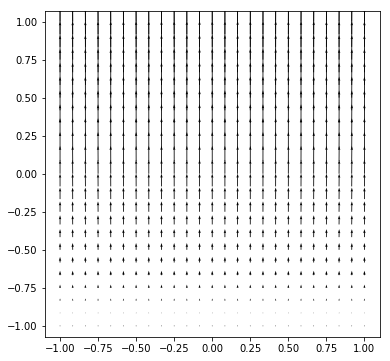

In [24]:
N,u = sdb.Query("SELECT N,u FROM uniaxial WHERE method='Silling' and weight='cubic' and N=25 and RF=1.5")[0]
u = u.reshape(N,N,2)
xx,yy = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))
ax = plt.gca()
ax.quiver(xx,yy,u[:,:,0],u[:,:,1],angles='uv',scale_units='xy',scale=10.0)
ax.set_aspect('equal', 'datalim')
plt.draw()

This is a shear problem and that does *look* like proper shear deformation. Let's take a look closer at the profile:

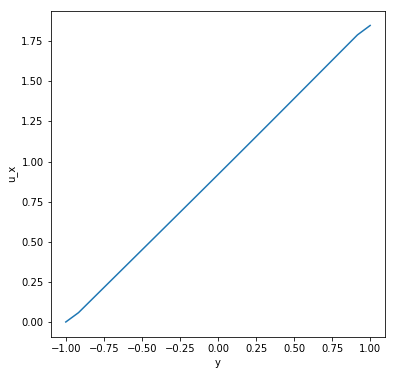

In [6]:
plt.plot(yy[:,N/2],u[:,N/2,1])
plt.xlabel('y'); plt.ylabel('u_x');

Notice how we can see the little dips at the end points where we get the well known edge effects. We can see them even more pronouced if we look at the other component of the solution:

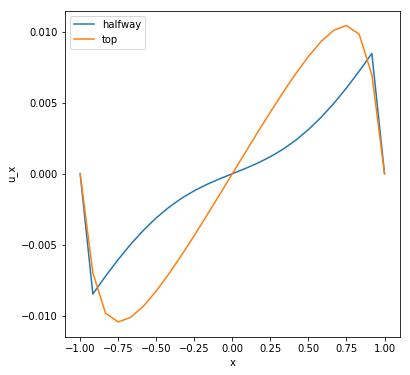

In [7]:
plt.plot(yy[:,N/2],u[N/2,:,0],label='halfway');
plt.plot(yy[:,N/2],u[-1,:,0],label='top');
plt.legend()
plt.xlabel('x'); plt.ylabel('u_x');

Upon closer inspection, we see that doesn't look good at all! This is a significant erroneous displacement! It also varies along the height, meaning that the 2D formulation model isn't handling the one-dimensional symmetry. 

### Error analysis

We've just noticed a few strange behaviors. But looking at just a few isolated plots isn't enough. We need to rigorously try out every hyperparameter set in each of the modes and evaluate the grid convergence properties. To do this, we calculate the error of the numerical method by comparing the displacement at the top edge of the domain with the above listed analytical solutions.

The Peridynamics literature is often confused about error analysis. It is important to note that the support radius of the influence function, $\delta$ is a **hyperparameter**. It is not a material property. Most papers do properly study the effect of the support radius, and cite the assertion that the Peridynamics formulation will 

By changing $h$ without changing $\delta$, the numerical method is changed because more points will be in the support radius. The stencil footprint thus changes. The proper path to grid convergence is to follow a path of fixed $RF=\delta/h$, keeping a constant stencil footprint. 



isotropic


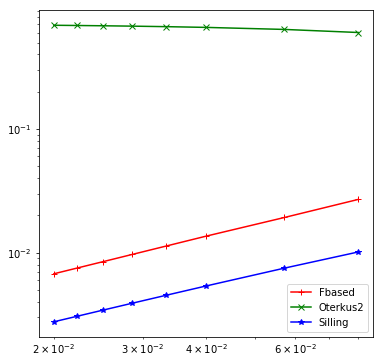

shear


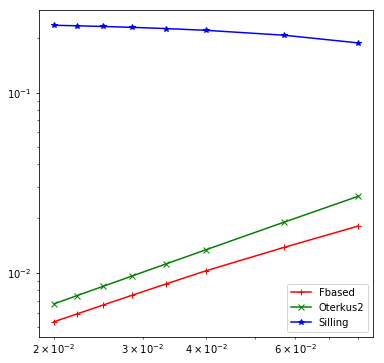

uniaxial


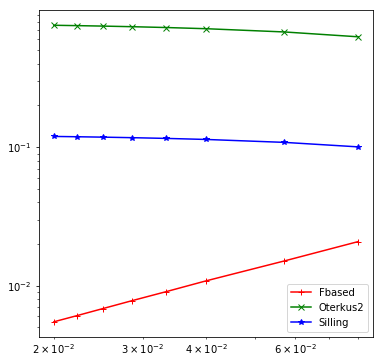

Convergence Rates:
<table><tr><td></td><td>isotropic</td><td>shear</td><td>uniaxial</td></tr><tr><td>Fbased</td><td>0.998518471486</td><td>0.88580762397</td><td>0.961508949756</td></tr><tr><td>Oterkus2</td><td>-0.0934425713562</td><td>0.992619961121</td><td>-0.133199906094</td></tr><tr><td>Silling</td><td>0.940215702548</td><td>-0.155718080685</td><td>-0.120152361872</td></tr></table>


,isotropic,shear,uniaxial
Fbased,0.998518471486,0.88580762397,0.961508949756
Oterkus2,-0.0934425713562,0.992619961121,-0.133199906094
Silling,0.940215702548,-0.155718080685,-0.120152361872


In [8]:
def e(tab,met):
    res = sdb.Query("SELECT N,u FROM {0} WHERE method='{1}' and weight='cubic' and RF=1.5".format(tab,met))
    errors = []
    hs = []
    for N,u in res:
        u = u.reshape(N,N,2)
        diff = (u[-1,:,solutions[tab][0]] - solutions[tab][1]).mean()
        errors.append(np.abs(diff/solutions[tab][1]))
        hs.append(2.0/float(N))
    return (hs,errors)
def rate(hs,es):
    return scipy.stats.linregress([np.log(h) for h in hs],
                                  [np.log(e) for e in es])[0]
methods = [_[0] for _ in sdb.Query("SELECT DISTINCT method FROM uniaxial")]
for t in tables:
    print t
    plt.figure()
    for m in methods:
        plt.loglog(*e(t,m),**mykwargs(m))
    plt.legend()
    plt.show()
print "Convergence Rates:"
print htmltable([[""]+tables] +
          [[m]+ [rate(*e(t,m)) for t in tables] for m in methods])
disptable([[""]+tables] +
          [[m]+ [rate(*e(t,m)) for t in tables] for m in methods])

For brevity, only the cubic weight function with RF=1.5 is shown above as it is the best case for all methods. Please refer to the above paper, Queiruga, 2017, to see a complete table with all of the influence functions and sweep through support radii. The database included in this repository contains all of the results.

This is also the verification that PeriFlakes is working correctly. These are the same results obtained by the previous codebase. However, these results are actually **atrocious**. A finite element program will get exactly correct results within machine precision for this set of problems with only one element. The two dilation based methods are invalid because they do not converge in all modes. We see that the F-based method is converging at a linear rate to the analytical solutions, which is poor for these problems, but perhaps we can work with it. We will notice it's unstable in the next section.


## Thin Crack

Those above problems are very crucial. Those disqualify the dilation based models as acceptable simulations, and show that the deformation gradient method isn't great as well. As much of a **red flag** it is that it only converges linearly to constant-strain problems, maybe it can perform decently for fracture problems.

Let's closely examine the behavior around a fracture, since that's the whole point of Peridynamics in the first place. We consider an infinitely large plate with a thin pressurized crack inside of it. To match the analytical solution with the finite domain, we apply the displacements of the analytical solution at the edges of the numerical domain as Dirichlet BCs. 

![cracks](images/crack_diagram.png)

PeriFlakes generates another database called `lfm_data.db` from the script file `lfm.py`. The database is filled with errors, runtimes, and displacement fields for another huge set of Peridynamic program configurations.

In [9]:
lsdb = SimDataDB('PeriFlakes/lfm_data.db')

Let us grab and plot the displacement field solution to the basic method we trust, F-based.

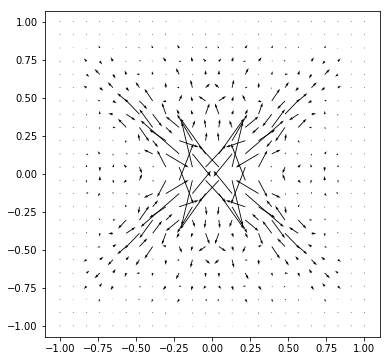

In [10]:
def draw_arrows(met,smo='',stab=0.0):
    N,u = lsdb.Query(
        "SELECT N,u FROM lfm WHERE method='{0}' and weight='cubic' and RF=1.5 and smoothing='{1}' and abs(stab-{2})<1.0e-8"
        .format(met,smo,stab))[0]
    u = u.reshape(N,N,2)
    xx,yy = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))
    ax = plt.gca()
    ax.quiver(xx[:,:],yy[:,:],u[:,:,0],u[:,:,1],angles='xy',scale_units='xy',scale=0.25)
    ax.set_aspect('equal', 'datalim')
    plt.draw()
draw_arrows('Fbased','');
mysavefig('quiver_Fbased.png');

This is the instability to the method. There are three ways we can try to fix it: post-processing to smooth the solution, or stabilize the matrix with one of two terms. We see that they all give us an improvement:

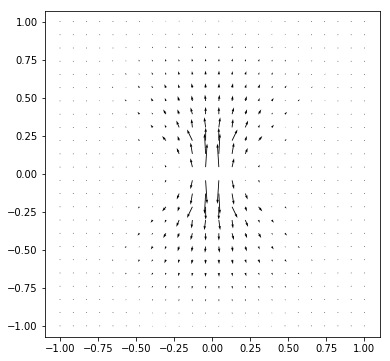

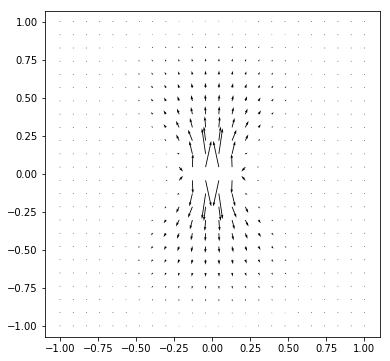

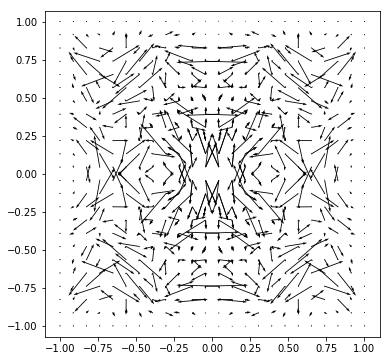

In [11]:
draw_arrows('Fbased','cubic')
mysavefig('quiver_Fbased_cubic.png');
plt.figure()
draw_arrows('Fstab_Silling','',2.0)
mysavefig('quiver_Fstab_Silling.png');
plt.figure()
draw_arrows('Fstab_Littlewood','',10.0);
mysavefig('quiver_Fstab_Littlewood.png');
draw_arrows('Fstab_Littlewood2011','',10.0);
mysavefig('quiver_Fstab_Littlewood2011.png');
draw_arrows('Fstab_Littlewood2011minus','',10.0);
mysavefig('quiver_Fstab_Littlewood2011minus.png');

It looks better in all cases, but the eye-ball norm isn't good enough. First, let us try out all of the different smoothing functions we wrote and judge them using the error norm we wrote above.

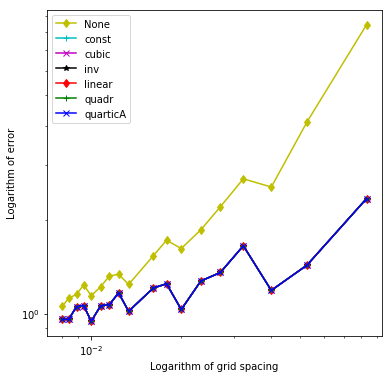

In [12]:
smooths = lsdb.Query("select distinct smoothing from lfm where method='Fbased'");
for smo in [ _[0] for _ in smooths ]:
    res = np.array(lsdb.Query("select N,error from lfm where method='Fbased' and smoothing='{0}'".format(smo)))
    plt.loglog(2.0/res[:,0],res[:,1],**mykwargs(smo if smo else "None"));
plt.xlabel('Logarithm of grid spacing');
plt.ylabel('Logarithm of error');
plt.legend();
mysavefig('smoothing_sweep.png');
plt.show();

It looks like all of the smoothing methods are just about the same, regardless of the weight kernel. We can also not that the support radius does not have to the be same as that used in the force laws (the smoothing horizon could be distinct from the Peridynamic horizon), but I prefer compact support where possible.

For the stabilized methods, we do a parameter sweep on the penalty:

Fstab_Silling


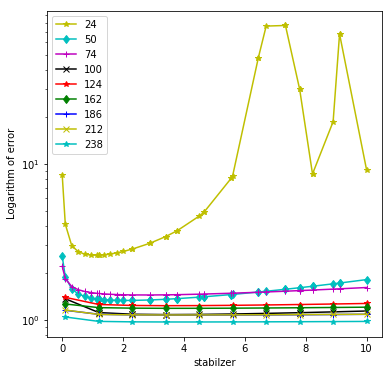

Fstab_Littlewood


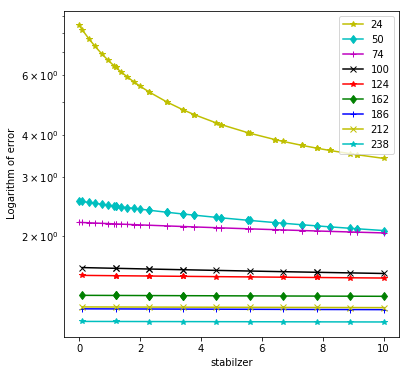

Fstab_Littlewood2011


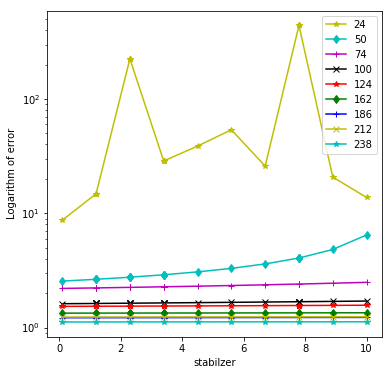

Fstab_Littlewood2011minus


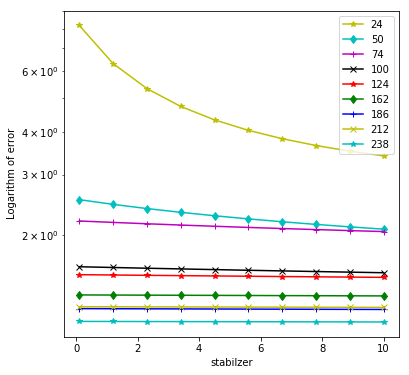

In [13]:
for met in ['Fstab_Silling','Fstab_Littlewood','Fstab_Littlewood2011','Fstab_Littlewood2011minus']:
    Ns = lsdb.Query("select distinct N from lfm where method='{0}'".format(met))
    for N in Ns[0::2]:
        res = np.array(lsdb.Query("select stab,error from lfm where method='{0}' and N={1}".format(met,N[0])))
        plt.semilogy(res[:,0],res[:,1],**mykwargs(str(N[0])));
    print met
    plt.legend();
    plt.xlabel('stabilzer');
    plt.ylabel('Logarithm of error');
    mysavefig('stabilizer_sweep_'+met+'.png');
    plt.show();

We see that Silling's stabilizer scales well with grid refinement, and the optimum value is at about one, like he suggested in his paper. Littlewood's stabilizer does not seem to scale though. I didn't push the stabilizer up any higher yet.

### Comparing all of the hyperparameters

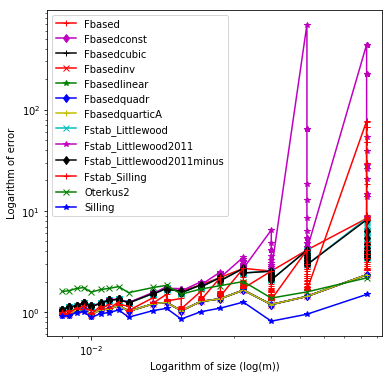

In [14]:
methods = lsdb.Query("SELECT DISTINCT method FROM lfm")
for met in methods:
    smooths = lsdb.Query("select distinct smoothing from lfm where method='{0}' and weight='cubic'".format(met[0]))
    for smo in smooths:
        res = np.array(lsdb.Query("select N,error,time from lfm where method='{0}' and weight='cubic' and smoothing='{1}'".format(met[0],smo[0])))
        plt.loglog(2.0/res[:,0],res[:,1],**mykwargs(met[0]+smo[0]))
plt.legend();
plt.xlabel('Logarithm of size (log(m))');
plt.ylabel('Logarithm of error');

That one is a little too cluttered. Let's just pick out the best ones:

In [15]:
lsdb.Query("select distinct stab from lfm where method='Fstab_Silling'")

[[0.0],
 [0.1],
 [0.3111111111111111],
 [0.5222222222222223],
 [0.7333333333333333],
 [0.9444444444444444],
 [1.1555555555555557],
 [1.2000000000000002],
 [1.3666666666666667],
 [1.577777777777778],
 [1.788888888888889],
 [2.0],
 [2.3000000000000003],
 [2.888888888888889],
 [3.4000000000000004],
 [3.7777777777777777],
 [4.5],
 [4.666666666666666],
 [5.555555555555555],
 [5.6],
 [6.444444444444445],
 [6.7],
 [7.333333333333333],
 [7.800000000000001],
 [8.222222222222221],
 [8.9],
 [9.11111111111111],
 [10.0]]

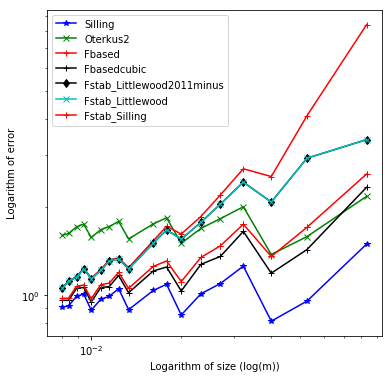

In [16]:
def _macro(met,wei,smo,sta):
    res = np.array(lsdb.Query("select N,error,time from lfm where method='{0}' and weight='{1}' and smoothing='{2}' and abs(stab-'{3}')<1.0e-3"
                              .format(met,wei,smo,sta)))
    plt.loglog(2.0/res[:,0],res[:,1],**mykwargs(met+smo))
_macro('Silling','cubic','',0.0)
_macro('Oterkus2','cubic','',0.0)
_macro('Fbased','cubic','',0.0)
_macro('Fbased','cubic','cubic',0.0)
_macro('Fstab_Littlewood2011minus','cubic','',10.0)
_macro('Fstab_Littlewood','cubic','',10.0)
_macro('Fstab_Silling','cubic','',1.2)
plt.legend();
plt.xlabel('Logarithm of size (log(m))');
plt.ylabel('Logarithm of error');
mysavefig('h_convergence_lfm.png');

### The FEM benchmark


In [17]:
fsdb = SimDataDB('fem/femdata.db')

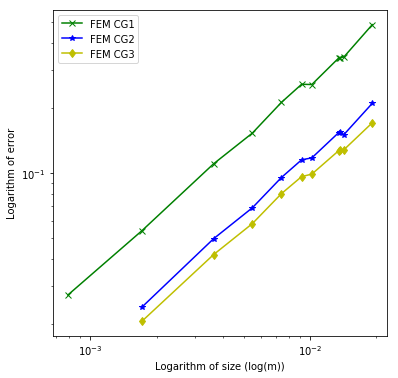

In [18]:
for po in [1,2,3]:
    res = np.array(fsdb.Query('select h,error,time from lfm where poly={0}'.format(po)))
    plt.loglog(res[:,0],res[:,1],**mykwargs('FEM CG'+str(po)))
plt.legend();
plt.xlabel('Logarithm of size (log(m))');
plt.ylabel('Logarithm of error');

We can see that the FEM model is converging, though not quite as expected. The issue that prevents the quadratic and cubic functions from converging more rapidly is actually the evaluation of the analytical solution. Due to its quirks around the crack, I couldn't get the error integral to be evaluated accurately enough without hitting Not-A-Numbers, so we are limited by the convergence of the error integral approximation. But, we can trust FEniCS.

## Runtime Comparison

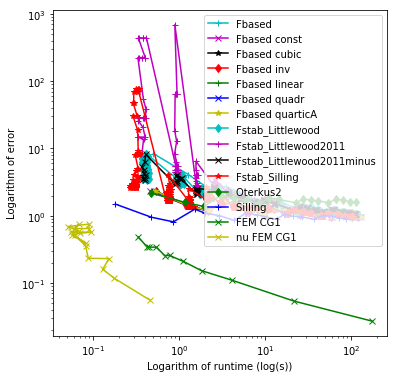

In [19]:
# Plot the errors in Peridynamics
for met in methods:
    smooths = lsdb.Query("select distinct smoothing from lfm where method='{0}' and weight='cubic'".format(met[0]))
    for smo in smooths:
        res = np.array(lsdb.Query("select N,error,time from lfm where method='{0}' and weight='cubic' and smoothing='{1}'".format(met[0],smo[0])))
        plt.loglog(res[:,2],res[:,1],**mykwargs(met[0]+' '+smo[0]))
# Plot the errors in FEM
for po in [1]:
    res = np.array(fsdb.Query('select h,error,time from lfm where poly={0}'.format(po)))
    plt.loglog(res[:,2],res[:,1],**mykwargs('FEM CG'+str(po)))
# Plot the errors with the nonuniform FEM
for po in [1]:
    res = np.array(fsdb.Query('select h,error,time from lfm_nonuniform where poly={0}'.format(po)))
    plt.loglog(res[:,2],res[:,1],**mykwargs('nu FEM CG'+str(po)))
plt.legend(loc=1);
plt.xlabel('Logarithm of runtime (log(s))');
plt.ylabel('Logarithm of error');
mysavefig('runtime_vs_error.png')

In these plots, the bottom left is better: faster runtime, lower error.

Something else we want to consider in addition to accuracy is the minimal representable resolution of a fracture. Because bond breaks are discrete events, the inherent size resolution to Peridynamics is the grid spacing.

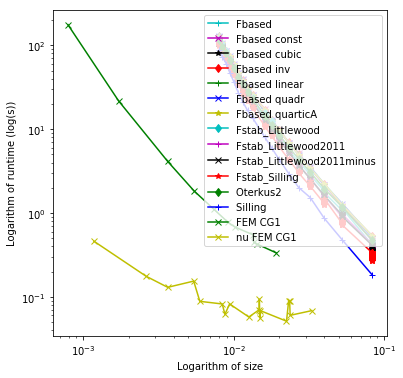

In [20]:
# Plot the errors in Peridynamics
for met in methods:
    smooths = lsdb.Query("select distinct smoothing from lfm where method='{0}' and weight='cubic'".format(met[0]))
    for smo in smooths:
        res = np.array(lsdb.Query("select N,error,time from lfm where method='{0}' and weight='cubic' and smoothing='{1}'".format(met[0],smo[0])))
        plt.loglog(2.0/res[:,0],res[:,2],**mykwargs(met[0]+' '+smo[0]))
# Plot the runtimes per size in FEM
for po in [1]:
    res = np.array(fsdb.Query('select h,error,time from lfm where poly={0}'.format(po)))
    plt.loglog(res[:,0],res[:,2],**mykwargs('FEM CG'+str(po)))
# Plot the errors in FEM
for po in [1]:
    res = np.array(fsdb.Query('select h,error,time from lfm_nonuniform where poly={0}'.format(po)))
    plt.loglog(res[:,0],res[:,2],**mykwargs('nu FEM CG'+str(po)))
plt.legend(loc=1);
plt.xlabel('Logarithm of size');
plt.ylabel('Logarithm of runtime (log(s))');
mysavefig('size_vs_runtime.png')

In these plots, the bottom left quadrant is better too: faster runtime for smaller representable lengths.